In [381]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split


In [2]:
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


In [4]:
API_URL = "https://archive-api.open-meteo.com/v1/archive"

# Function to create dataframe of weather parameters with timestamp

In [195]:
def get_dataframe(data):
    response = data[0]
    daily = response.Daily()

    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_rain_sum = daily.Variables(1).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(2).ValuesAsNumpy()

    daily_data = {"timestamp": pd.date_range(
	 start = pd.to_datetime(daily.Time(), unit = "s"),
	 end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	 freq = pd.Timedelta(seconds = daily.Interval()),
	 inclusive = "left"
    )}


    daily_data["temperature_max"] = daily_temperature_2m_max
    daily_data["rain_sum"] = daily_rain_sum
    daily_data["wind_speed_max"] = daily_wind_speed_10m_max

    daily_dataframe = pd.DataFrame(data = daily_data)
    
    
    
    #hourly_dataframe['timestamp'] = hourly_dataframe['date'].dt.time
    #hourly_dataframe['date'] = hourly_dataframe['date'].dt.date
    #print(hourly_dataframe) 
   
    #seasonal_averages = hourly_dataframe['time'].resample('Q').mean()
    return daily_dataframe
    
    

# Function to Calculate Seasonal Average

In [1]:
def calculate_seasonal_averages(df):
   
    df['month'] = df['timestamp'].dt.month
    
    seasons = {
        'Spring': [1, 2, 3],
        'Summer': [4, 5, 6],
        'Rainy': [7, 8, 9],
        'Winter': [10, 11, 12]
    }

    
    df['season'] = df['month'].apply(lambda month: next(season for season, months in seasons.items() if month in months))

    
    seasonal_averages = df.groupby(['year','season']).mean()

    return seasonal_averages,df

# Function to plot time-series daily values

In [358]:

def plot_time_series(df, city, parameter):

    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[parameter], label=f'{city} - {parameter}')
    
    plt.xlabel('Date')
    plt.ylabel(parameter)
    plt.title(f'Time Series - {parameter} for {city}')
    plt.legend()
    plt.show()
    


# Function predicting next day’s weather parameter using Linear Regression.

In [2]:
def build_linear_regression_model(df, features, target, test_size=0.2, random_state=42):

    
    
    df_copy = df.copy()
    df_copy['next_day_target'] = df_copy[target].shift(-1)

    
    df_copy.dropna(inplace=True)
   

    
    X = df_copy[features].values.reshape(-1, len(features))
    y = df_copy['next_day_target'].values

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    
    model = LinearRegression()
    model.fit(X_train, y_train)

    
    y_pred = model.predict(X_test)
    
    X_next_day = df.tail(1)[features].values
    predicted_next_day = model.predict(X_next_day)
    # df.drop('next_day_target', axis=1)
    # df.drop('next_day', axis=1)
    accuracy = model.score(X_test, y_test)
    print("Accuracy = ", accuracy)
    return predicted_next_day[0] 

   

# Comparing different lengths of historical data

In [474]:
def compare_prediction_lengths(df, features, target, test_size=0.2, random_state=None, prediction_days=1):
    model_accuracies = []
    prediction_changes = []

    for length in range(30, len(df), 30):
        subset_df = df.head(length)
        
        predicted_next_day = build_linear_regression_model(subset_df, features, target, test_size, random_state)
        
        #model_accuracies.append(accuracy)
        prediction_changes.append(predicted_next_day)

    plt.figure(figsize=(12, 6))
    plt.plot(range(30, len(df), 30), prediction_changes, label= f'Predicted Next Day {target}')
    plt.title(f'Predicted Next Day {target} vs. Historical Data Length')
    plt.xlabel('Historical Data Length')
    plt.ylabel(f'Predicted Next Day {target}')
    plt.legend()
    plt.show()


# Define parameters for Nagpur and Hyd 

In [196]:


nagpur_params = {
    "latitude": 21.15,
    "longitude": 79.09,
    "start_date": "2023-02-27",
    "end_date": "2024-01-10",
    "daily": ["temperature_2m_max", "rain_sum", "wind_speed_10m_max"]
}

# Define parameters for Hyderabad
hyderabad_params = {
    "latitude": 17.38,
    "longitude": 78.48,
    "start_date": "2023-02-27",
    "end_date": "2024-01-10",
    "daily": ["temperature_2m_max", "rain_sum", "wind_speed_10m_max"]
}



# Fetch weather data for Nagpur and Hyd

In [286]:

nagpur_response = openmeteo.weather_api(API_URL, params=nagpur_params)
nagpur_data = nagpur_response

# Fetch weather data for Hyderabad
hyderabad_response = openmeteo.weather_api(API_URL, params=hyderabad_params)
hyderabad_data = hyderabad_response

In [439]:
df_1 = get_dataframe(nagpur_data)
df_2 = get_dataframe(hyderabad_data)

In [360]:
df_1.head()

,timestamp,temperature_max,rain_sum,wind_speed_max
0,2023-02-27,34.754498,0.0,16.299694
1,2023-02-28,34.504498,0.0,10.383987
2,2023-03-01,34.104500,0.0,13.049689
3,2023-03-02,34.854500,0.0,11.119281
4,2023-03-03,35.554497,0.0,9.957108


In [361]:
df_2.head()

,timestamp,temperature_max,rain_sum,wind_speed_max
0,2023-02-27,33.516499,0.0,14.512064
1,2023-02-28,33.166500,0.0,15.408671
2,2023-03-01,33.016499,0.0,15.790833
3,2023-03-02,33.416500,0.0,14.182355
4,2023-03-03,34.416500,0.0,17.877180


In [409]:
df_2.isna().all()


timestamp          False
temperature_max    False
rain_sum           False
wind_speed_max     False
year               False
next_day_target    False
dtype: bool

In [362]:


df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_1['year'] = df_1['timestamp'].dt.year

df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])
df_2['year'] = df_2['timestamp'].dt.year

df_1.head()

,timestamp,temperature_max,rain_sum,wind_speed_max,year
0,2023-02-27,34.754498,0.0,16.299694,2023
1,2023-02-28,34.504498,0.0,10.383987,2023
2,2023-03-01,34.104500,0.0,13.049689,2023
3,2023-03-02,34.854500,0.0,11.119281,2023
4,2023-03-03,35.554497,0.0,9.957108,2023


# Calculating Annual Averages for Hyd and nagpur


In [202]:
nagpur_annual_averages =  df_1.groupby(['year']).mean()
hyderabad_annual_averages =  df_2.groupby(['year']).mean()



In [203]:
print(nagpur_annual_averages)
print(hyderabad_annual_averages)

               timestamp  temperature_max  rain_sum  wind_speed_max
year                                                               
2023 2023-07-30 12:00:00        33.099789   4.51461       15.042122
2024 2024-01-05 12:00:00        28.064503   0.56000       10.927236
               timestamp  temperature_max  rain_sum  wind_speed_max
year                                                               
2023 2023-07-30 12:00:00        31.748644  3.142208        16.80418
2024 2024-01-05 12:00:00        27.631500  0.050000        15.47755


# Calculating Seasonal Averages for Hyd and nagpur

In [204]:
nagpur_seasonal_averages, nagpur_df = calculate_seasonal_averages(df_1)
hyderabad_seasonal_averages, hyderabad_df = calculate_seasonal_averages(df_2)


In [205]:
print(nagpur_seasonal_averages)


                      timestamp  temperature_max   rain_sum  wind_speed_max  \
year season                                                                   
2023 Rainy  2023-08-15 12:00:00        30.999607  11.657609       15.296933   
     Spring 2023-03-15 00:00:00        33.895409   0.945455       15.775104   
     Summer 2023-05-16 00:00:00        37.873180   2.793407       18.257811   
     Winter 2023-11-15 12:00:00        30.193087   0.354348       11.343659   
2024 Spring 2024-01-05 12:00:00        28.064503   0.560000       10.927236   

                 month  
year season             
2023 Rainy    7.989130  
     Spring   2.939394  
     Summer   5.000000  
     Winter  11.000000  
2024 Spring   1.000000  


In [206]:
print(hyderabad_seasonal_averages)

                      timestamp  temperature_max  rain_sum  wind_speed_max  \
year season                                                                  
2023 Rainy  2023-08-15 12:00:00        29.912151  6.329348       21.068270   
     Spring 2023-03-15 00:00:00        32.805893  1.754546       13.667374   
     Summer 2023-05-16 00:00:00        35.157707  2.558242       17.522032   
     Winter 2023-11-15 12:00:00        29.833891  1.030435       12.955200   
2024 Spring 2024-01-05 12:00:00        27.631500  0.050000       15.477550   

                 month  
year season             
2023 Rainy    7.989130  
     Spring   2.939394  
     Summer   5.000000  
     Winter  11.000000  
2024 Spring   1.000000  


# 2. Calculate and tabulate the results of differences in weather parameters between Nagpur and Hyd.

In [215]:
differences = df_2[['temperature_max', 'rain_sum', 'wind_speed_max']] - df_1[['temperature_max', 'rain_sum', 'wind_speed_max']]

In [216]:
df_3 = pd.DataFrame(differences, df_1['month'])
df_3.head()


,temperature_max,rain_sum,wind_speed_max
month,,,
2,-1.088001,0.0,2.741143
2,-1.088001,0.0,2.741143
3,-1.438000,0.0,3.063074
3,-1.438000,0.0,3.063074
3,-1.438000,0.0,3.063074


In [217]:
annual_differences = df_3.groupby('month').mean()

In [218]:
print("Annual Differences in Weather Parameters (Nagpur - Hyderabad):")
print(annual_differences)

Annual Differences in Weather Parameters (Nagpur - Hyderabad):
       temperature_max  rain_sum  wind_speed_max
month                                           
1            -1.337997       0.0        5.024684
2            -1.088001       0.0        2.741143
3            -1.438000       0.0        3.063074
4            -1.137997       0.0        7.920073
5            -1.388000       0.0       -0.211235
6            -0.438000       0.0       -1.622675
7            -0.337997      -0.5       -4.573981
8             2.461998      -0.3       -5.475382
9             0.262001       0.0       -0.525975
10            0.161999       0.0       -4.471156
11            0.562000       0.0       -2.281863
12           -1.288002       0.0        0.556840


In [219]:
print(tabulate(annual_differences, headers='keys', tablefmt='pretty'))

+-------+---------------------+----------------------+----------------------+
| month |   temperature_max   |       rain_sum       |    wind_speed_max    |
+-------+---------------------+----------------------+----------------------+
|   1   | -1.3379974365234375 |         0.0          |  5.024683952331543   |
|   2   | -1.0880012512207031 |         0.0          |  2.741143226623535   |
|   3   | -1.4379997253417969 |         0.0          |  3.0630741119384766  |
|   4   | -1.1379966735839844 |         0.0          |  7.920072555541992   |
|   5   |  -1.38800048828125  |         0.0          | -0.21123504638671875 |
|   6   | -0.4379997253417969 |         0.0          | -1.6226749420166016  |
|   7   | -0.3379974365234375 |         -0.5         |  -4.573981285095215  |
|   8   | 2.4619979858398438  | -0.30000001192092896 |  -5.475381851196289  |
|   9   | 0.26200103759765625 |         0.0          |  -0.525975227355957  |
|  10   | 0.16199874877929688 |         0.0          |  -4.47115

# 3. Plot time-series “daily” values of weather parameters.


In [363]:
df_1.set_index('timestamp', inplace=True)
df_2.set_index('timestamp', inplace=True)

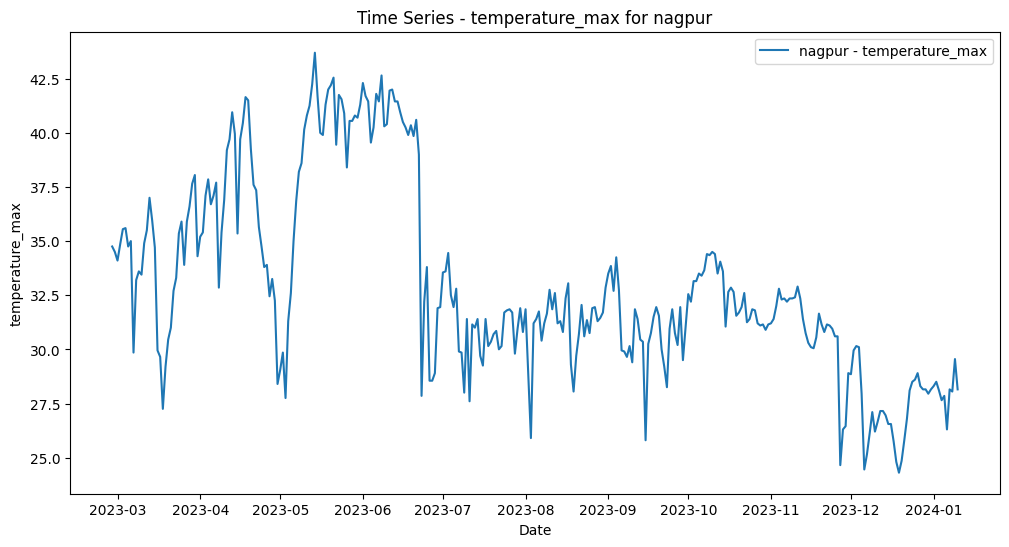

In [364]:
plot_time_series(df_1, 'nagpur', 'temperature_max')

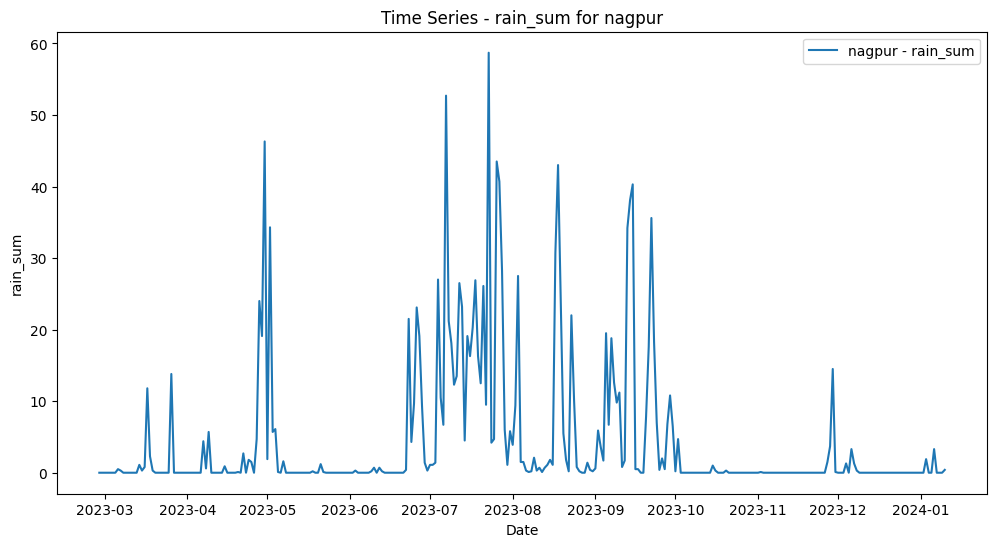

In [365]:
plot_time_series(df_1, 'nagpur', 'rain_sum')

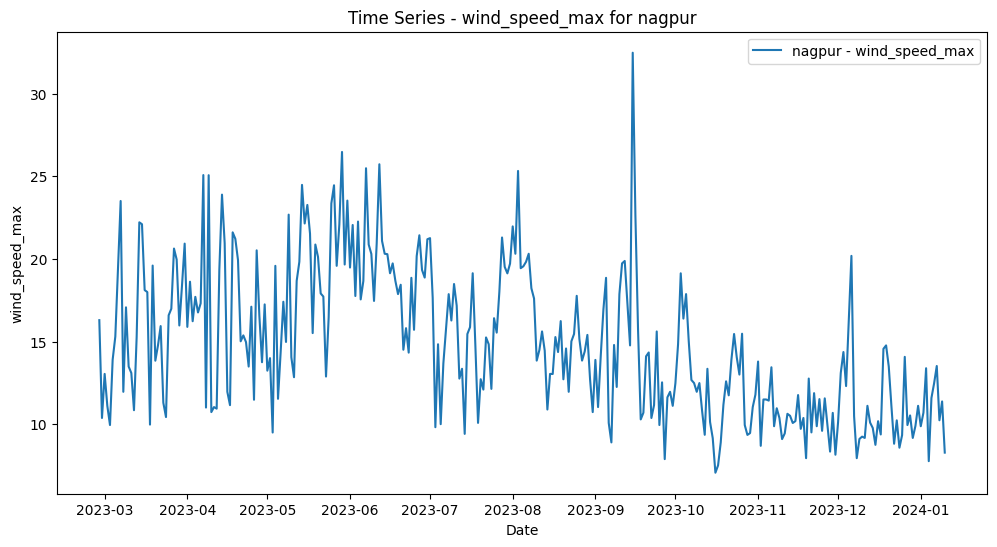

In [366]:

plot_time_series(df_1, 'nagpur', 'wind_speed_max')


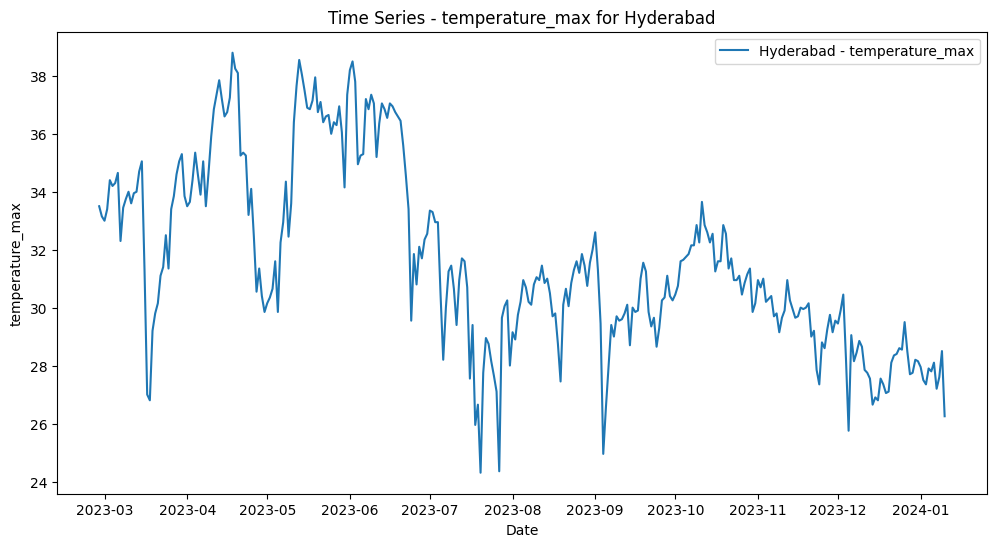

In [346]:
plot_time_series(df_2, 'Hyderabad', 'temperature_max')

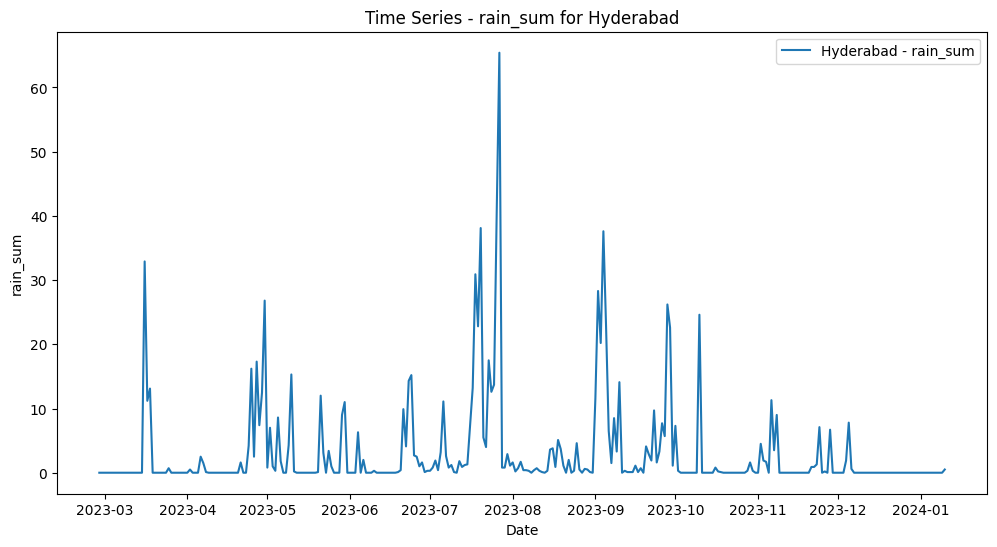

In [367]:

plot_time_series(df_2, 'Hyderabad', 'rain_sum')


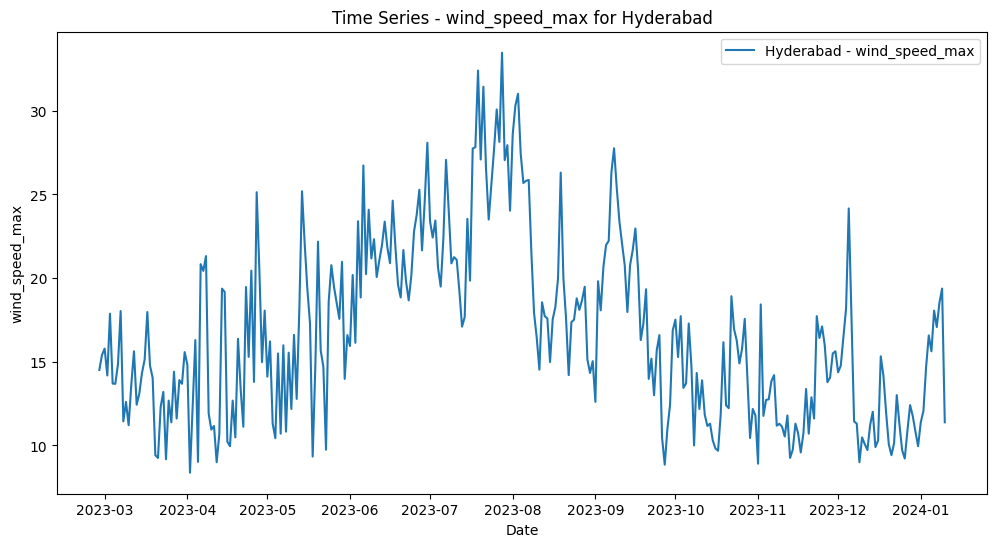

In [368]:
plot_time_series(df_2, 'Hyderabad', 'wind_speed_max')


# 4. Predicting next day  weather parmeters using Linear regression model .

In [430]:
df_1 = df_1.reset_index(drop=False)
df_2 = df_2.reset_index(drop=False)

In [440]:
df_1.tail()

,timestamp,temperature_max,rain_sum,wind_speed_max
313,2024-01-06,26.304501,3.3,12.481153
314,2024-01-07,28.154501,0.0,13.527572
315,2024-01-08,28.054501,0.0,10.245780
316,2024-01-09,29.554501,0.0,11.384198
317,2024-01-10,28.154501,0.4,8.287822


In [453]:
features = ['temperature_max', 'rain_sum', 'wind_speed_max']

temp = build_linear_regression_model(df_1, features,'temperature_max')
print("Predicted Temperature = " , temp)

Accuracy =  0.8814241240113116
Predicted Temperature =  27.907995


In [442]:
build_linear_regression_model(df_1, features,'rain_sum')

2.4181461

In [443]:
build_linear_regression_model(df_1, features,'wind_speed_max')

12.516184

In [444]:
build_linear_regression_model(df_2, features,'temperature_max')

28.612978

In [446]:
build_linear_regression_model(df_2, features,'rain_sum')

1.6231897

In [447]:
build_linear_regression_model(df_2, features,'wind_speed_max')

16.945591

# Compare different lengths of historical data and see if the prediction changes.

Accuracy =  -1.7346406385945499
Accuracy =  0.4068211523751081
Accuracy =  0.817143047165286
Accuracy =  0.8463525959758271
Accuracy =  0.8931507756062037
Accuracy =  0.69464426352206
Accuracy =  0.8802301791145508
Accuracy =  0.8589685675961077
Accuracy =  0.8472837378339069
Accuracy =  0.8516376052071405


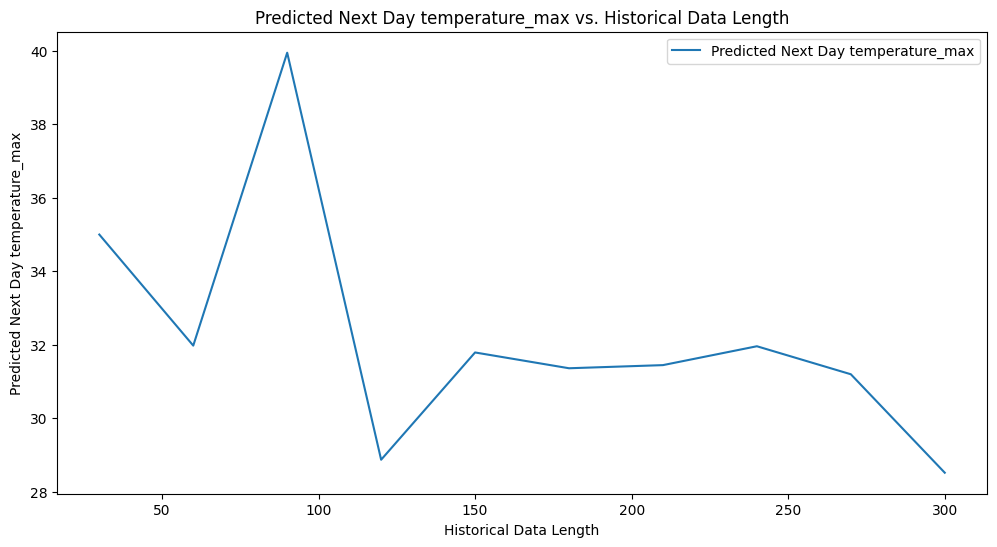

In [480]:
compare_prediction_lengths(df_1, features, 'temperature_max', test_size=0.2, random_state=42)

Accuracy =  -1.233251957828771
Accuracy =  -0.008961817029022434
Accuracy =  0.23835282725226858
Accuracy =  0.3021906446611784
Accuracy =  0.3384496264846818
Accuracy =  0.03310917720529649
Accuracy =  0.36520160573875493
Accuracy =  0.3798524373647343
Accuracy =  0.37944868422794076
Accuracy =  0.44750674424953496


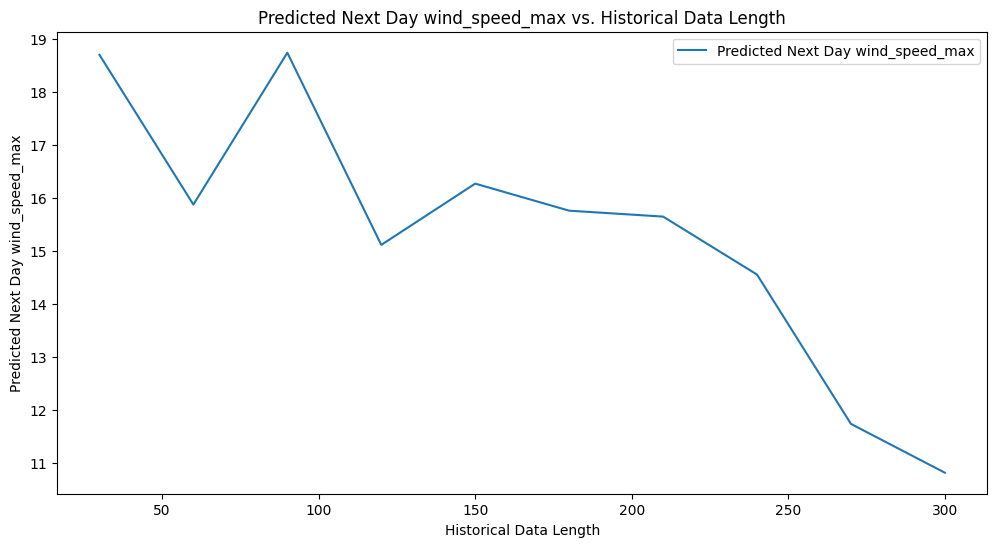

In [479]:
compare_prediction_lengths(df_1, features, 'wind_speed_max', test_size=0.2, random_state=42)

Accuracy =  -47.013796777563286
Accuracy =  -1.3651428757495996
Accuracy =  0.12249707138995392
Accuracy =  -0.21192224977714513
Accuracy =  -0.03765160923840849
Accuracy =  0.10446378004208745
Accuracy =  0.4694289777373378
Accuracy =  0.26934884713545426
Accuracy =  0.29738934500936
Accuracy =  0.08566411789722339


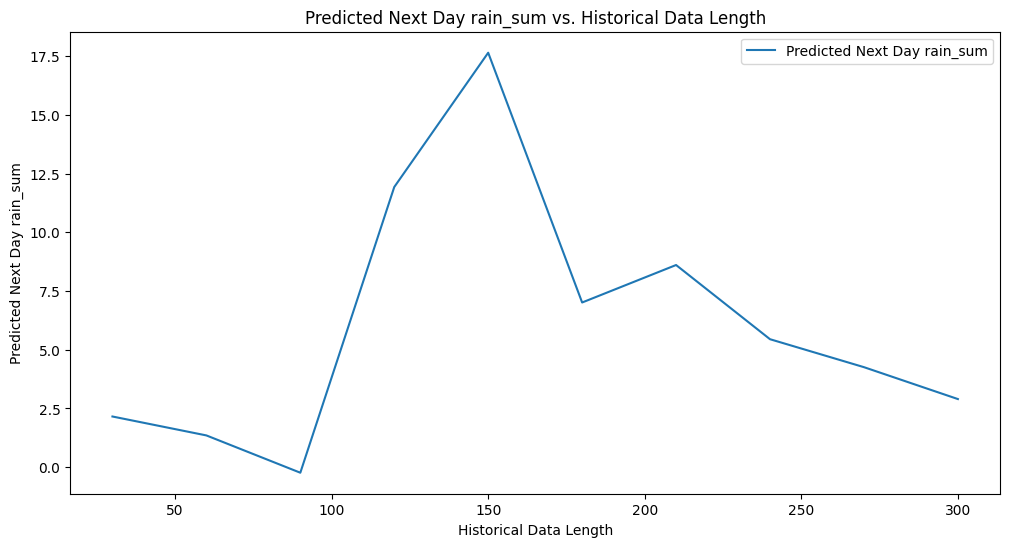

In [478]:
compare_prediction_lengths(df_1, features, 'rain_sum', test_size=0.2, random_state=42)

Accuracy =  -0.43141424303889053
Accuracy =  -0.5919090486381224
Accuracy =  0.23786652765885774
Accuracy =  0.2689216671653616
Accuracy =  0.5125905903573909
Accuracy =  0.5608871962958526
Accuracy =  0.5101548291408047
Accuracy =  0.5983213045565203
Accuracy =  0.6176746119245479
Accuracy =  0.4850311889709852


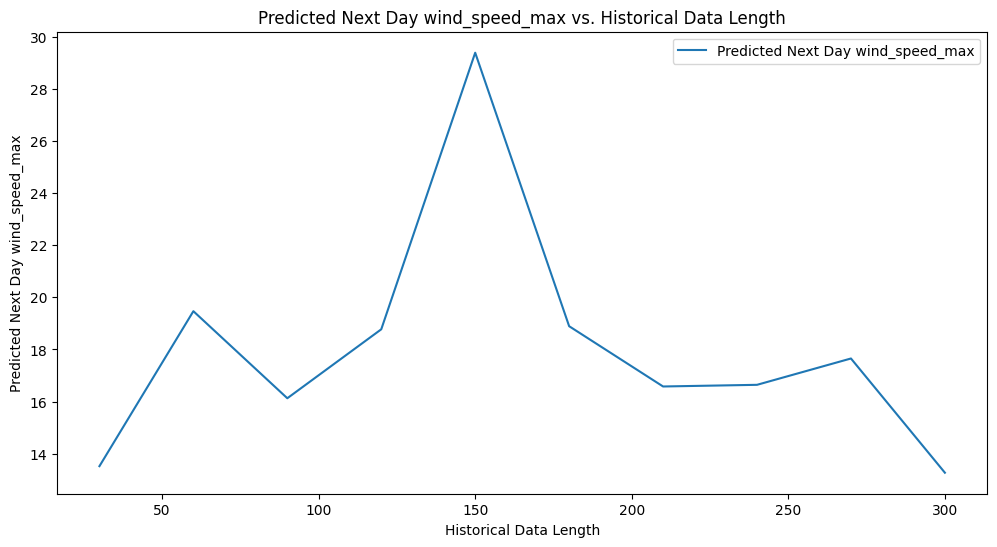

In [477]:
compare_prediction_lengths(df_2, features, 'wind_speed_max', test_size=0.2, random_state=42)

Accuracy =  -0.3251744993642258
Accuracy =  0.7690330303677522
Accuracy =  0.9148445038531026
Accuracy =  0.8126246203317199
Accuracy =  0.8388679963082407
Accuracy =  0.8710535698416486
Accuracy =  0.8890232316892462
Accuracy =  0.7505092067629249
Accuracy =  0.679878870575139
Accuracy =  0.8183647535971954


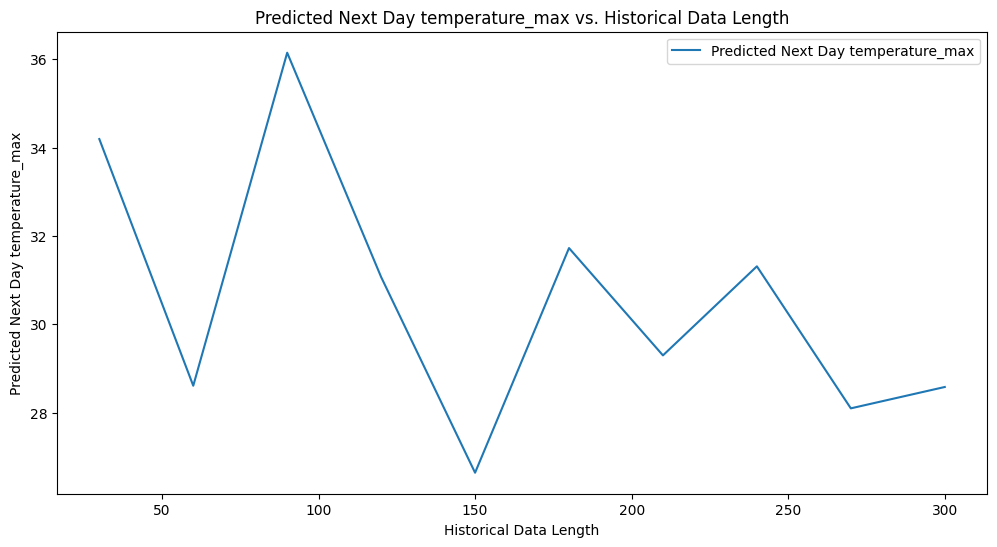

In [476]:
compare_prediction_lengths(df_2, features, 'temperature_max', test_size=0.2, random_state=42)

Accuracy =  -0.21598125589640582
Accuracy =  -9.550075175007555
Accuracy =  0.22511841528108378
Accuracy =  0.13325103405631966
Accuracy =  0.2563620177264374
Accuracy =  0.18663097324781108
Accuracy =  0.23619799714726297
Accuracy =  -0.12083209689405527
Accuracy =  -1.6091709351006305
Accuracy =  0.31498499726531093


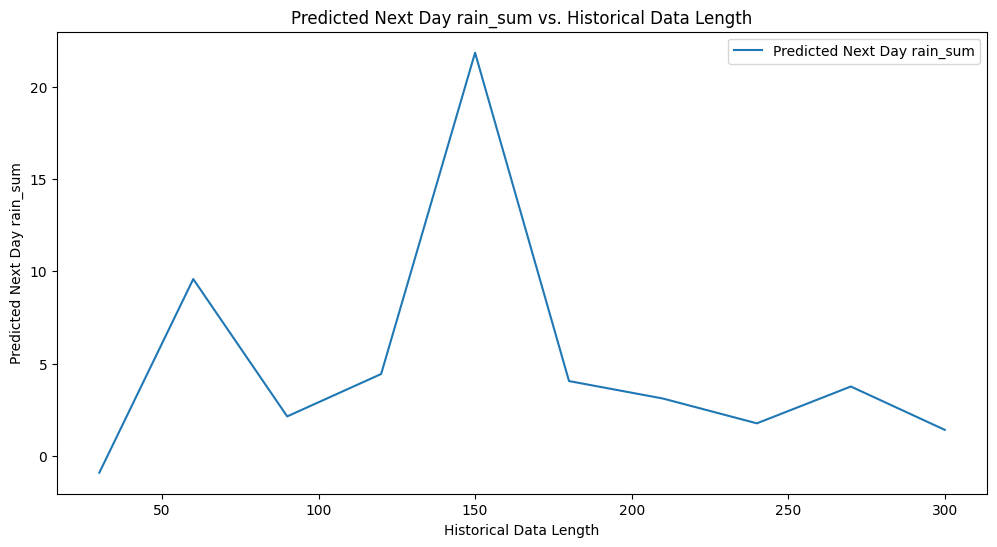

In [475]:
compare_prediction_lengths(df_2, features, 'rain_sum', test_size=0.2, random_state=42)